## Directory Setting

In [1]:
import os
import sys, os

path=os.getcwd()
path2=os.path.dirname(path)
sys.path.append(os.path.join(f'{path}', f'{path2}'))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dezero import Variable
import dezero.functions as F
import random
import pandas as pd
import matplotlib.pyplot as plot
import time

## Materials

In [3]:
Ag=pd.read_csv('Ag.csv', index_col=0)
Ag=Ag[(Ag['Wavelength']>=380)&(Ag['Wavelength']<=780)]
Ag_comp=Ag['n']-1j*Ag['k']
Ag=np.array([Ag_comp]).T

WO3=pd.read_csv('WO3.csv', index_col=0)
WO3=WO3[(WO3['Wavelength']>=380)&(WO3['Wavelength']<=780)]
WO3_comp=WO3['n']-1j*WO3['k']
WO3=np.array([WO3_comp]).T

SiO2=np.arange(380, 781)/1000
SiO2=np.array([(np.sqrt((1.28604141+((1.07044083*(SiO2**2))/((SiO2**2)-1.00585997*(10**-2)))+((1.10202242*(SiO2**2))/(SiO2**2-100)))))])
SiO2=SiO2.T

kn=pd.read_csv('k.csv')
kn=kn[(kn['Wavelength']>=380)&(kn['Wavelength']<=780)]['k']
kn=np.array([kn.values]).T

B=pd.read_csv('B.csv')
B=B[(B['Wavelength']>=380)*(B['Wavelength']<=780)]
B=B.iloc[:,1:2].to_numpy()
B=Variable(B)

Wavelength=pd.read_csv('B.csv')['Wavelength']

## Parameter Setting

In [4]:
a1=Variable(np.array(1.0))
b1=Variable(np.array(0.0))
c1=Variable(np.array(0.0))
d1=Variable(np.array(1.0))

ninc=Variable(np.array(1.0))
n1=Variable(WO3)
n2=Variable(Ag)
n3=Variable(WO3)
n4=Variable(Ag)
n5=Variable(WO3)
nsub=Variable(SiO2)

k=Variable(kn)

spectrum=B

## Network Setting

In [5]:
def predict(k):
    a2=F.Mat1(t1, a1, b1, c1, d1, n1, k)
    b2=F.Mat2(t1, a1, b1, c1, d1, n1, k)
    c2=F.Mat3(t1, a1, b1, c1, d1, n1, k)
    d2=F.Mat4(t1, a1, b1, c1, d1, n1, k)
 
    a3=F.Mat1(t2, a2, b2, c2, d2, n2, k)
    b3=F.Mat2(t2, a2, b2, c2, d2, n2, k)
    c3=F.Mat3(t2, a2, b2, c2, d2, n2, k)
    d3=F.Mat4(t2, a2, b2, c2, d2, n2, k)
    
    a4=F.Mat1(t3, a3, b3, c3, d3, n3, k)
    b4=F.Mat2(t3, a3, b3, c3, d3, n3, k)
    c4=F.Mat3(t3, a3, b3, c3, d3, n3, k)
    d4=F.Mat4(t3, a3, b3, c3, d3, n3, k)
    
    a5=F.Mat1(t4, a4, b4, c4, d4, n4, k)
    b5=F.Mat2(t4, a4, b4, c4, d4, n4, k)
    c5=F.Mat3(t4, a4, b4, c4, d4, n4, k)
    d5=F.Mat4(t4, a4, b4, c4, d4, n4, k)
    
    a6=F.Mat1(t5, a5, b5, c5, d5, n5, k)
    b6=F.Mat2(t5, a5, b5, c5, d5, n5, k)
    c6=F.Mat3(t5, a5, b5, c5, d5, n5, k)
    d6=F.Mat4(t5, a5, b5, c5, d5, n5, k)
    
    B=F.B(a6, b6, c6, d6, nsub)
    C=F.C(a6, b6, c6, d6, nsub)
    
    y=F.T(ninc, nsub, B, C)    
    
    return y

## Inverse Design. STEP1

In [6]:
st=time.time()

t1=Variable(np.full((401,1), 100E-9))
t2=Variable(np.full((401,1), 10E-9))
t3=Variable(np.full((401,1), 15E-9))
t4=Variable(np.full((401,1), 15E-9))
t5=Variable(np.full((401,1), 90E-9))

lr = 1E-9
beta1=0.9
beta2=0.999

iters_num = 200
m1=0; m2=0; m3=0; m4=0; m5=0;
v1=0; v2=0; v3=0; v4=0; v5=0;
   
for it in range(iters_num):
    iters=it+1
    y_pred=predict(k)
    loss = F.mean_squared_error(spectrum, y_pred)

    t1.cleargrad()
    t2.cleargrad()
    t3.cleargrad()
    t4.cleargrad()
    t5.cleargrad()
    loss.backward()
    
    m1       = m1*beta1 + (1-beta1)*t1.grad.data.real
    m1_hat   = m1/(1-beta1**iters)
    v1       = v1*beta2 + (1-beta2)*((t1.grad.data.real)**2)
    v1_hat   = v1/(1-beta2**iters)
    t1.data -= lr * m1_hat/(np.sqrt(v1_hat)+1e-7)
    t1.data[t1.data < 0] = 0

    m2       = m2*beta1 + (1-beta1)*t2.grad.data.real
    m2_hat   = m2/(1-beta1**iters)
    v2       = v2*beta2 + (1-beta2)*((t2.grad.data.real)**2)
    v2_hat   = v2/(1-beta2**iters)
    t2.data -= lr * m2_hat/(np.sqrt(v2_hat)+1e-7)
    t2.data[t2.data < 0] = 0
   
    m3       = m3*beta1 + (1-beta1)*t3.grad.data.real
    m3_hat   = m3/(1-beta1**iters)
    v3       = v3*beta2 + (1-beta2)*((t3.grad.data.real)**2)
    v3_hat   = v3/(1-beta2**iters)
    t3.data -= lr * m3_hat/(np.sqrt(v3_hat)+1e-7)
    t3.data[t3.data < 0] = 0
    
    m4       = m4*beta1 + (1-beta1)*t4.grad.data.real
    m4_hat   = m4/(1-beta1**iters)
    v4       = v4*beta2 + (1-beta2)*((t4.grad.data.real)**2)
    v4_hat   = v4/(1-beta2**iters)
    t4.data -= lr * m4_hat/(np.sqrt(v4_hat)+1e-7)
    t4.data[t4.data < 0] = 0
    
    m5       = m5*beta1 + (1-beta1)*t5.grad.data.real
    m5_hat   = m5/(1-beta1**iters)
    v5       = v5*beta2 + (1-beta2)*((t5.grad.data.real)**2)
    v5_hat   = v5/(1-beta2**iters)
    t5.data -= lr * m5_hat/(np.sqrt(v5_hat)+1e-7)
    t5.data[t5.data < 0] = 0

et=time.time()

## Inverse Design. STEP2

In [7]:
rst_loss=np.array([])
t_1=t1
t_2=t2
t_3=t3
t_4=t4
t_5=t5

for nn in range(len(t_1)):
    t1=Variable(np.full((401,1), t_1.data[nn]))
    t2=Variable(np.full((401,1), t_2.data[nn]))
    t3=Variable(np.full((401,1), t_3.data[nn]))
    t4=Variable(np.full((401,1), t_4.data[nn]))
    t5=Variable(np.full((401,1), t_5.data[nn]))

    y_test=predict(k)
    loss=F.mean_squared_error(spectrum, y_test)

    rst_loss=np.append(rst_loss, loss.data)

m=np.argmin(rst_loss)
print('t1_thickness: ', t_1.data[m][0]*1E+9, 'nm')
print('t2_thickness: ', t_2.data[m][0]*1E+9, 'nm')
print('t3_thickness: ', t_3.data[m][0]*1E+9, 'nm')
print('t4_thickness: ', t_4.data[m][0]*1E+9, 'nm')
print('t5_thickness: ', t_5.data[m][0]*1E+9, 'nm')

t1_thickness:  116.07018201712206 nm
t2_thickness:  18.855392434123573 nm
t3_thickness:  31.448135286572512 nm
t4_thickness:  13.806880188824476 nm
t5_thickness:  105.90705107681886 nm


In [8]:
t1=Variable(np.full((401,1), t_1.data[m]))
t2=Variable(np.full((401,1), t_2.data[m]))
t3=Variable(np.full((401,1), t_3.data[m]))
t4=Variable(np.full((401,1), t_4.data[m]))
t5=Variable(np.full((401,1), t_5.data[m]))

y_rst=predict(k)

## Plot Result

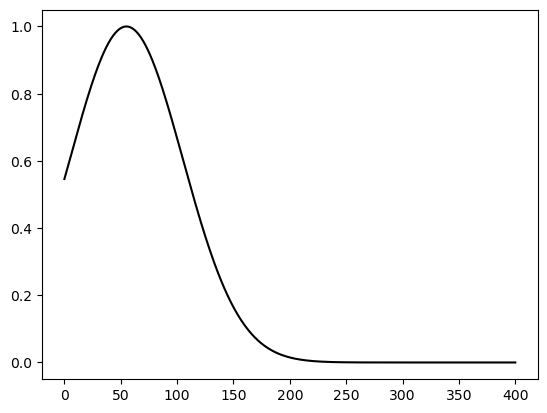

In [9]:
plt.plot(spectrum.data, color='k')

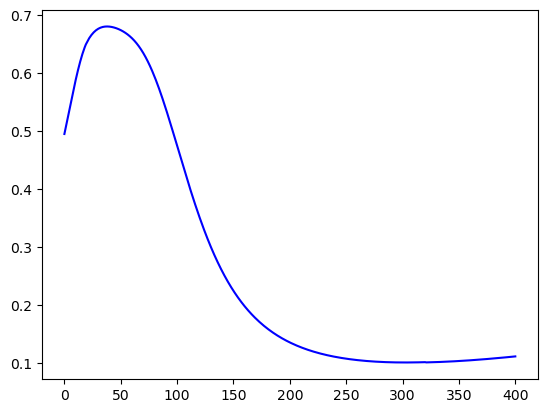

In [10]:
plt.plot(y_rst.data, color='b')

## Running Time

In [11]:
run_time = et-st
print('Run_Time:', run_time)

Run_Time: 1.8071739673614502
